In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# random data
np.random.seed(1)
X = np.random.uniform(0, 5, 10).reshape(-1, 1)  # 10 random data points
y = np.sin(X).ravel() + np.random.normal(0, 0.1, X.shape[0])  # get the target value with some noise

# kernel
kernel = C(1.0, (1e-4, 1e1)) * RBF(1.0, (1e-4, 1e1))


gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)

# training
gp.fit(X, y)

# prediction
X_pred = np.linspace(0, 5, 100).reshape(-1, 1)  
y_pred, sigma = gp.predict(X_pred, return_std=True)

plt.figure()
plt.plot(X, y, 'r.', markersize=10, label='Observations')
plt.plot(X_pred, y_pred, 'b-', label='Prediction')
plt.fill_between(X_pred.ravel(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, color='blue', alpha=0.2)
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Gaussian Process Regression')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

Test Mean Squared Error: 0.012988217175006866


C:\Users\plc03\anaconda3\envs\ac_grammar_vae\lib\site-packages\gpytorch\models\exact_gp.py:283: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


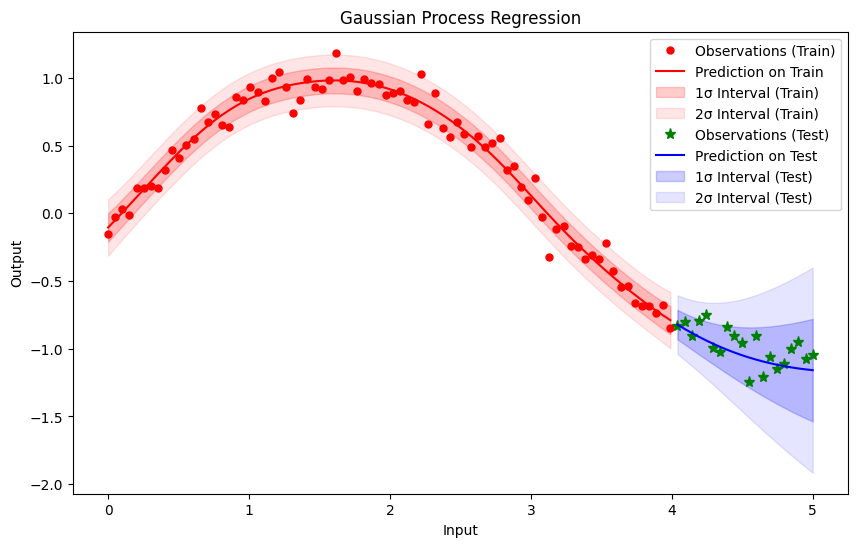

In [2]:
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt

# set the random seed
torch.manual_seed(1)
np.random.seed(1)

# define the Model
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()  
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) 
        
        #choose different mean functions
        #self.mean_module = gpytorch.means.LinearMean()
        #self.mean_module = MyPolynomialMean(degree=2)
        #self.mean_module = gpytorch.means.ConstantPlusLinearMean()
        #self.mean_module = gpytorch.means.ZeroMean()
        
        #choose different kernel functions here
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5))
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PolynomialKernel(power=2))
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RationalQuadraticKernel())
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel() + gpytorch.kernels.PeriodicKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

x = torch.linspace(0, 5, 100)  
y = torch.sin(x) + torch.randn(x.size()) * 0.1  

train_size = int(0.8 * len(x))  # 80% for training
test_size = len(x) - train_size  # 20% for testing

train_x, test_x = torch.split(x, [train_size, test_size])
train_y, test_y = torch.split(y, [train_size, test_size])

# initialisation
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(train_x, train_y, likelihood)

# train the model
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()

# evaluate
model.eval()
likelihood.eval() 

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    train_pred = likelihood(model(train_x))
    train_mean = train_pred.mean
    train_lower, train_upper = train_pred.confidence_region()
    

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    test_pred = likelihood(model(test_x))
    test_mean = test_pred.mean
    lower, upper = observed_pred.confidence_region()
    
test_mse = torch.mean((test_mean - test_y) ** 2).item()
print(f'Test Mean Squared Error: {test_mse}')


# visualisation
plt.figure(figsize=(10, 6))
plt.plot(train_x.numpy(), train_y.numpy(), 'r.', markersize=10, label='Observations (Train)')
plt.plot(train_x.numpy(), train_mean.numpy(), 'r-', label='Prediction on Train')
plt.fill_between(train_x.numpy(), (train_mean - train_pred.stddev).numpy(), (train_mean + train_pred.stddev).numpy(), color='red', alpha=0.2, label='1σ Interval (Train)')
plt.fill_between(train_x.numpy(), (train_mean - 2*train_pred.stddev).numpy(), (train_mean + 2*train_pred.stddev).numpy(), color='red', alpha=0.1, label='2σ Interval (Train)')

plt.plot(test_x.numpy(), test_y.numpy(), 'g*', markersize=8, label='Observations (Test)')
plt.plot(test_x.numpy(), test_mean.numpy(), 'b-', label='Prediction on Test')
plt.fill_between(test_x.numpy(), (test_mean - test_pred.stddev).numpy(), (test_mean + test_pred.stddev).numpy(), color='blue', alpha=0.2, label='1σ Interval (Test)')
plt.fill_between(test_x.numpy(), (test_mean - 2*test_pred.stddev).numpy(), (test_mean + 2*test_pred.stddev).numpy(), color='blue', alpha=0.1, label='2σ Interval (Test)')

plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Gaussian Process Regression')
plt.legend()
# plt.savefig(r'D:\24SS\MA\files\2D_GP_Prediction.png', format='png', dpi=300) 
plt.show()



Test Mean Squared Error: 0.009496964514255524


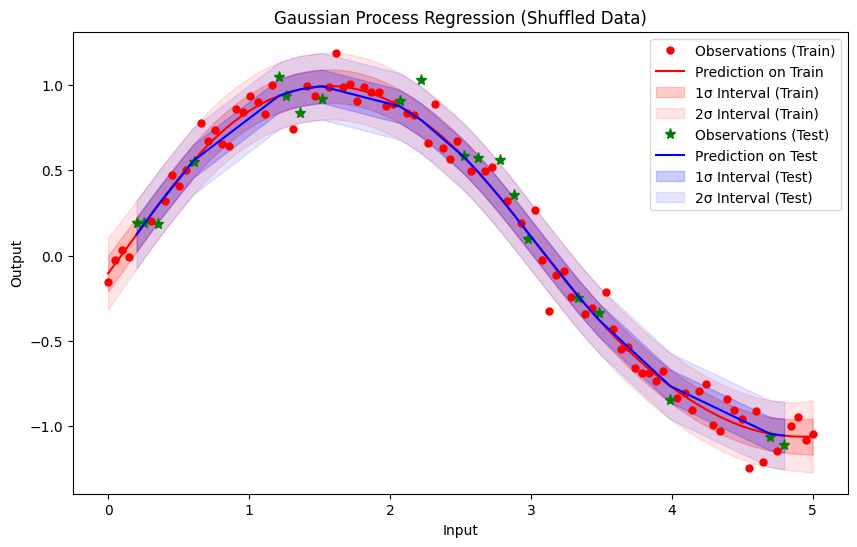

In [3]:
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt

# set the random seed
torch.manual_seed(1)
np.random.seed(1)

# define the Model
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()  
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) 
        
        #choose different mean functions
        #self.mean_module = gpytorch.means.LinearMean()
        #self.mean_module = MyPolynomialMean(degree=2)
        #self.mean_module = gpytorch.means.ConstantPlusLinearMean()
        #self.mean_module = gpytorch.means.ZeroMean()
        
        #choose different kernel functions here
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5))
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PolynomialKernel(power=2))
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RationalQuadraticKernel())
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel() + gpytorch.kernels.PeriodicKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Generate data
x = torch.linspace(0, 5, 100)  
y = torch.sin(x) + torch.randn(x.size()) * 0.1  # add some noise

# Shuffle the data
perm = torch.randperm(len(x))
x = x[perm]
y = y[perm]

# Split into train and test sets
train_size = int(0.8 * len(x))  # 80% for training
test_size = len(x) - train_size  # 20% for testing

train_x, test_x = torch.split(x, [train_size, test_size])
train_y, test_y = torch.split(y, [train_size, test_size])

# Initialisation
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(train_x, train_y, likelihood)

# Train the model
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()

# Evaluate
model.eval()
likelihood.eval() 

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    train_pred = likelihood(model(train_x))
    train_mean = train_pred.mean
    train_lower, train_upper = train_pred.confidence_region()
    
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    test_pred = likelihood(model(test_x))
    test_mean = test_pred.mean
    lower, upper = observed_pred.confidence_region()
    
test_mse = torch.mean((test_mean - test_y) ** 2).item()
print(f'Test Mean Squared Error: {test_mse}')

# Visualisation
# Sort the data for plotting to avoid confusion in the visualization
sorted_train_x, sorted_indices_train = torch.sort(train_x)
sorted_train_y = train_y[sorted_indices_train]
sorted_train_mean = train_mean[sorted_indices_train]
sorted_train_pred = train_pred.stddev[sorted_indices_train]

sorted_test_x, sorted_indices_test = torch.sort(test_x)
sorted_test_y = test_y[sorted_indices_test]
sorted_test_mean = test_mean[sorted_indices_test]
sorted_test_pred = test_pred.stddev[sorted_indices_test]

# Visualisation with sorted data
plt.figure(figsize=(10, 6))
plt.plot(sorted_train_x.numpy(), sorted_train_y.numpy(), 'r.', markersize=10, label='Observations (Train)')
plt.plot(sorted_train_x.numpy(), sorted_train_mean.numpy(), 'r-', label='Prediction on Train')
plt.fill_between(sorted_train_x.numpy(), (sorted_train_mean - sorted_train_pred).numpy(), (sorted_train_mean + sorted_train_pred).numpy(), color='red', alpha=0.2, label='1σ Interval (Train)')
plt.fill_between(sorted_train_x.numpy(), (sorted_train_mean - 2*sorted_train_pred).numpy(), (sorted_train_mean + 2*sorted_train_pred).numpy(), color='red', alpha=0.1, label='2σ Interval (Train)')

plt.plot(sorted_test_x.numpy(), sorted_test_y.numpy(), 'g*', markersize=8, label='Observations (Test)')
plt.plot(sorted_test_x.numpy(), sorted_test_mean.numpy(), 'b-', label='Prediction on Test')
plt.fill_between(sorted_test_x.numpy(), (sorted_test_mean - sorted_test_pred).numpy(), (sorted_test_mean + sorted_test_pred).numpy(), color='blue', alpha=0.2, label='1σ Interval (Test)')
plt.fill_between(sorted_test_x.numpy(), (sorted_test_mean - 2*sorted_test_pred).numpy(), (sorted_test_mean + 2*sorted_test_pred).numpy(), color='blue', alpha=0.1, label='2σ Interval (Test)')

plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Gaussian Process Regression (Shuffled Data)')
plt.legend()
#plt.savefig(r'D:\24SS\MA\files\2D_GP_Prediction_shuffled.png', format='png', dpi=300) 
plt.show()

In [4]:
#Expand to 2D-data
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook 

# set the random seed
torch.manual_seed(1)
np.random.seed(1)

# define the Model
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()  
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) 
        
        #choose different mean functions
        #self.mean_module = gpytorch.means.LinearMean()
        #self.mean_module = MyPolynomialMean(degree=2)
        #self.mean_module = gpytorch.means.ConstantPlusLinearMean()
        #self.mean_module = gpytorch.means.ZeroMean()
        
        #choose different kernel functions here
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5))
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PolynomialKernel(power=2))
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RationalQuadraticKernel())
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel() + gpytorch.kernels.PeriodicKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
# Generate 2D data
# Generate 2D data
x1 = torch.linspace(0, 5, 20)
x2 = torch.linspace(0, 5, 20)
x1, x2 = torch.meshgrid(x1, x2, indexing='ij')  # Updated with 'indexing' argument
x = torch.stack([x1.flatten(), x2.flatten()], dim=-1)


# Create a 2D sinusoidal pattern with noise as the target
y = torch.sin(x[:, 0]) * torch.cos(x[:, 1]) + torch.randn(x.size(0)) * 0.1

# Shuffle data
perm = torch.randperm(x.size(0))
x, y = x[perm], y[perm]

# Split into train and test sets
train_size = int(0.8 * len(x))
test_size = len(x) - train_size
train_x, test_x = torch.split(x, [train_size, test_size])
train_y, test_y = torch.split(y, [train_size, test_size])


# initialisation
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(train_x, train_y, likelihood)

# train the model
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 5
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()

# evaluate
model.eval()
likelihood.eval() 

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    train_pred = likelihood(model(train_x))
    train_mean = train_pred.mean
    train_lower, train_upper = train_pred.confidence_region()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    test_pred = likelihood(model(test_x))
    test_mean = test_pred.mean
    lower, upper = observed_pred.confidence_region()
    
test_mse = torch.mean((test_mean - test_y) ** 2).item()
print(f'Test Mean Squared Error: {test_mse}')


# 3D Visualization
# 3D Visualization with improved resolution and colormap
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')
# Plot the training data as blue points and test data as red points
ax.scatter(train_x[:, 0].numpy(), train_x[:, 1].numpy(), train_y.numpy(), c='blue', label='Train Data')
ax.scatter(test_x[:, 0].numpy(), test_x[:, 1].numpy(), test_y.numpy(), c='red', label='Test Data')
ax.set_title('Train and Test Data in 3D')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
ax.legend()

ax2 = fig.add_subplot(122, projection='3d')
# Plot the prediction surface with a colormap and higher resolution
surf = ax2.plot_trisurf(test_x[:, 0].numpy(), test_x[:, 1].numpy(), test_mean.numpy(), cmap='viridis', alpha=0.9)
fig.colorbar(surf, ax=ax2, shrink=0.5, aspect=5, label='Predicted Y')  # Add a color bar to explain the colormap
ax2.set_title('GP Prediction Surface in 3D')
ax2.set_xlabel('X1')
ax2.set_ylabel('X2')
ax2.set_zlabel('Predicted Y')

plt.show()

Test Mean Squared Error: 0.013869677670300007


<IPython.core.display.Javascript object>

In [5]:
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set random seeds for reproducibility
torch.manual_seed(1)
np.random.seed(1)

# Define the GP model class
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()  
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Generate 2D data
x1, x2 = torch.meshgrid(torch.linspace(0, 5, 20), torch.linspace(0, 5, 20), indexing='ij')
x = torch.stack([x1.flatten(), x2.flatten()], dim=-1)
y = torch.sin(x[:, 0]) * torch.cos(x[:, 1]) + torch.randn(x.size(0)) * 0.1

# Shuffle data
perm = torch.randperm(x.size(0))
x, y = x[perm], y[perm]

# Split data
train_size = int(0.8 * len(x))
train_x, test_x = torch.split(x, [train_size, len(x) - train_size])
train_y, test_y = torch.split(y, [train_size, len(y) - train_size])

# Initialize model and likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(train_x, train_y, likelihood)

# Train model
model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
for i in range(5):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()

# Switch to evaluation mode
model.eval()
likelihood.eval()

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    train_pred = likelihood(model(train_x))
    train_mean = train_pred.mean
    train_stddev = train_pred.stddev
    test_pred = likelihood(model(test_x))
    test_mean = test_pred.mean
    test_stddev = test_pred.stddev

# Plotting
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(train_x[:, 0].numpy(), train_x[:, 1].numpy(), train_y.numpy(), color='blue', label='Train Data')
ax.scatter(test_x[:, 0].numpy(), test_x[:, 1].numpy(), test_y.numpy(), color='red', label='Test Data')
ax.set_title('Training and Testing Data')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
ax.legend()

# Prediction Surface with Confidence Intervals
ax2 = fig.add_subplot(122, projection='3d')
test_x_np = test_x.numpy()
#zorder = 10  # Base z-order for plotting surfaces
ax2.plot_trisurf(test_x_np[:, 0], test_x_np[:, 1], (test_mean.numpy() + 2 * test_stddev.numpy()), color='lightblue', alpha=0.2)
ax2.plot_trisurf(test_x_np[:, 0], test_x_np[:, 1], (test_mean.numpy() + test_stddev.numpy()), color='blue', alpha=0.5)
ax2.plot_trisurf(test_x_np[:, 0], test_x_np[:, 1], test_mean.numpy(), color='deepskyblue', alpha=0.9)
ax2.plot_trisurf(test_x_np[:, 0], test_x_np[:, 1], (test_mean.numpy() - test_stddev.numpy()), color='blue', alpha=0.5)
ax2.plot_trisurf(test_x_np[:, 0], test_x_np[:, 1], (test_mean.numpy() - 2 * test_stddev.numpy()), color='lightblue', alpha=0.2)
ax2.set_title('GP Prediction Surface in 3D for test data')
ax2.set_xlabel('X1')
ax2.set_ylabel('X2')
ax2.set_zlabel('Predicted Y')

# 假设数据和绘图代码
colors = ['lightblue', 'blue', 'deepskyblue']
labels = ['2σ Interval Upper', '1σ Interval Upper', 'Mean Prediction']
from matplotlib.patches import Patch

# 为每个标签和颜色创建图例条目
legend_handles = [Patch(facecolor=color, label=label) for color, label in zip(colors, labels)]

# 添加图例
ax2.legend(handles=legend_handles, loc='upper right')

plt.savefig(r'D:\24SS\MA\files\3D_GP_Prediction.png', format='png', dpi=300)  



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>